# SPSS Modelerの平均値ノードをPythonで書き換える。

SPSS Modeler ノードリファレンス 6-9 平均値 - Qiita 
https://qiita.com/416nishimaki/items/f5b957a24430b9a3aa9e

平均値ノード - IBM Documentation 
https://www.ibm.com/docs/ja/spss-modeler/18.4.0?topic=nodes-means-node

# ２つのフィールドの平均を比較

In [1]:
import pandas as pd
#!wget 'https://raw.githubusercontent.com/hkwd/200611Modeler2Python/master/mean/t-test.csv'
df=pd.read_csv('t-test.csv')
df

,顧客ID,実施後,実施前
0,1,36020,36435
1,2,40883,37143
2,3,43307,43307
3,4,44130,44130
4,5,45193,44093
...,...,...,...
547,548,107290,112190
548,549,120250,123300
549,550,112530,115830
550,551,117440,117440


In [2]:
details=True
columns=['実施後','実施前']


sttest=pd.Series({'フィールド1':[columns[0]],
                        'フィールド2':[columns[1]]})

#列の基本指標
for i,col in enumerate(columns):
    sttest['平均'+str(i+1)+'m']=df[col].mean()
    if details==True:
        sttest['平均'+str(i+1)+'s']=df[col].std()
        sttest['平均'+str(i+1)+'se']=df[col].sem()
        sttest['平均'+str(i+1)+'n']=len(df[col])

#相関係数
from scipy import stats
r,p=stats.pearsonr(df[columns[0]],df[columns[1]])
sttest['相関係数']=r
sttest['相関係数検定1-p']=1-p


#平均値差
m = abs(df[columns[0]].mean()-df[columns[1]].mean())
s = (df[columns[0]]-df[columns[1]]).std()

# 対応ある2標本のt検定
t,p=stats.ttest_rel(df[columns[0]],df[columns[1]])
se =  m/t
n = len(df[columns[0]])

d_f = len(df[columns[0]])-1
ci = stats.t.interval( alpha=0.95, loc=m, scale=se, df=d_f )

sttest['平均差m']=m
if details==True :
    sttest['平均差s']=s
    sttest['平均差se']=se
    sttest['平均差n']=n
    sttest['95%信頼区間下限']=ci[0]
    sttest['95%信頼区間上限']=ci[1]

    sttest['T検定']=t
    sttest['自由度']=d_f
sttest['T検定1-p']=1-p

pd.options.display.float_format = '{:.3f}'.format

dttest=pd.DataFrame([sttest])
dttest

,フィールド1,フィールド2,平均1m,平均1s,平均1se,平均1n,平均2m,平均2s,平均2se,平均2n,...,相関係数検定1-p,平均差m,平均差s,平均差se,平均差n,95%信頼区間下限,95%信頼区間上限,T検定,自由度,T検定1-p
0,[実施後],[実施前],81379.500,37466.900,1594.697,552,69644.741,37106.005,1579.336,552,...,1.000,11734.759,31430.918,1337.789,552,9106.969,14362.549,8.772,551,1.000


Python で無相関検定をしてみる - GIS奮闘記 https://www.gis-py.com/entry/hypothesis-testing

【統計】Pythonでt検定をやってみる | naoの学習＆学習 https://www.learning-nao.com/?p=2620
Pythonでt検定 2クラスの試験成績の比較 - Qiita https://qiita.com/code0327/items/a96dd2fbd8a491d2eeaa

# 複数カテゴリの平均を比較

In [3]:
#!wget 'https://raw.githubusercontent.com/hkwd/200611Modeler2Python/master/mean/anova1.csv'
df1=pd.read_csv('anova1.csv')
df1

,ブランド,イメージスコア
0,L,30.000
1,L,31.000
2,L,32.000
3,L,33.000
4,L,34.000
...,...,...
1381,A,91.000
1382,A,92.000
1383,A,93.000
1384,A,94.000


In [4]:
#対象列定義
grpcolumn='ブランド'
testcolumns=['イメージスコア']
df1[grpcolumn]=df1[grpcolumn].astype("category")

def anova(df1, testcolumns,grpcolumn,details=False):
    danova=pd.DataFrame()
    for i,col in enumerate(testcolumns):
        sanova=pd.Series({'フィールド':col})
        
        #列の基本指標
        for cat in df1[grpcolumn].cat.categories:
            sanova[cat+'平均']=df1.query(grpcolumn+'==@cat')[col].mean()
            if details==True:
                sanova[cat+'s']=df1.query(grpcolumn+'==@cat')[col].std()
                sanova[cat+'se']=df1.query(grpcolumn+'==@cat')[col].sem()
                sanova[cat+'n']=len(df1.query(grpcolumn+'==@cat')[col])
        #一元配置分散分析
        from statsmodels.formula.api import ols
        model = ols(col+' ~ ' + grpcolumn, data=df1).fit()                
        import statsmodels.api as sm
        anov = sm.stats.anova_lm(model)
        anov
        if details==True:
            sanova['F検定']=anov.loc[grpcolumn,'F']
            sanova['自由度']=anov.loc[grpcolumn,'df']
        sanova['F検定1-p']=1-anov.loc[grpcolumn,'PR(>F)']

        
        danova=pd.concat([danova,pd.DataFrame([sanova])])
    return danova
anova(df1, testcolumns,grpcolumn,details=False)

,フィールド,A平均,B平均,L平均,M平均,N平均,O平均,F検定1-p
0,イメージスコア,84.991,79.996,39.996,29.996,59.996,74.996,1.000


In [5]:
#カテゴリ比較箱ひげ図
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


def boxplot(df, testcolumns,grpcolumn):
    sns.set(font='Meiryo')
    for col in testcolumns:
        fig = plt.figure(figsize=(20, 3), constrained_layout=True)
        ax = fig.add_subplot(1, 1, 1)
        sns.boxplot(x=grpcolumn, y=col,
                    data=df, showfliers=False, ax=ax)
        plt.show()



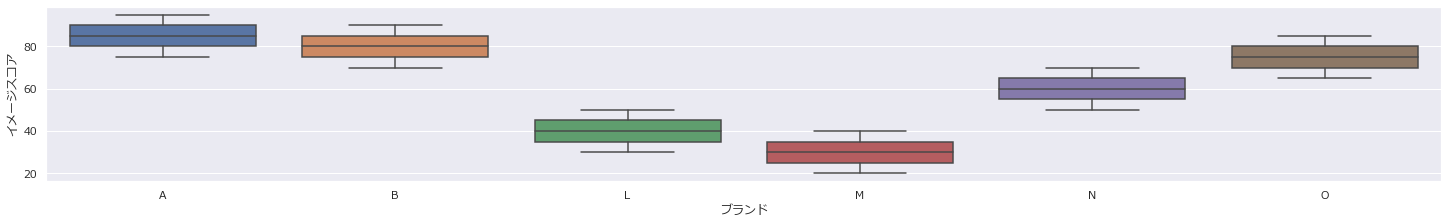

In [6]:
boxplot(df1,testcolumns,grpcolumn)


# 複数カテゴリの複数フィールドの平均を比較

In [7]:
#!wget 'https://raw.githubusercontent.com/hkwd/200611Modeler2Python/master/mean/goodcustomer.csv'
df2=pd.read_csv('goodcustomer.csv',encoding='sjis')
df2

,CUSTID,マネタリー5,大分類_アクセサリ_小計_Sum,大分類_インナーウエア_小計_Sum,大分類_バッグ_小計_Sum,大分類_化粧品_小計_Sum,大分類_婦人服_小計_Sum,大分類_靴_小計_Sum,大分類_食品_小計_Sum,Monetary,...,大分類_靴_小計_Sum_全体比,大分類_食品_小計_Sum_全体比,リーセンシスコア,フリクエンシスコア,マネタリースコア,名前,年代,入会後年数,昨年累積金額,昨年Mrank
0,100001,F,8278,7715,7243,26885,6026,26870,15707,98724,...,0.272,0.159,5,4,3,宮森 J子,40代,1,369754,MrankA
1,100004,F,0,47262,10342,35251,19631,45890,11700,170076,...,0.270,0.069,3,4,4,南森 J穂,40代,5,35020,MrankC
2,100005,F,10500,0,0,0,0,0,108460,118960,...,0.000,0.912,1,2,3,山島 S美,40代,7,341221,MrankA
3,100006,F,0,26210,14400,33000,11460,0,0,85070,...,0.000,0.000,2,2,3,宮下 C子,20代,6,3000643,MrankB
4,100008,F,1017,21755,2800,13441,2950,11123,1194,54280,...,0.205,0.022,4,3,2,武瀬 J子,40代,1,50725,MrankC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,105967,T,0,0,57800,6980,118619,0,121144,304543,...,0.000,0.398,5,4,5,鈴岡 N子,40代,9,351232,MrankA
2996,105970,T,0,13621,12602,130994,53489,132122,13527,356355,...,0.371,0.038,2,4,5,富下 S子,40代,5,2960931,MrankA
2997,105972,F,75558,0,0,2964,20730,35780,0,135032,...,0.265,0.000,2,3,4,福矢 N子,30代,1,351232,MrankA
2998,105974,T,0,40225,12930,89600,42289,54602,3920,243566,...,0.224,0.016,3,5,5,武井 S穂,40代,2,351232,MrankA


In [8]:
import re
grpcolumn='マネタリー5'
testcolumns=[]
#数値列のみが比較対象
for col in df2:
    if re.sub(r'[0-9]+', '', df2[col].dtype.name) in ['int', 'float']:
        testcolumns.append(col)

df2[grpcolumn]=df2[grpcolumn].astype("category")
#分散分析
df_anova=anova(df2, testcolumns,grpcolumn,details=True).sort_values('F検定',ascending=False)
df_anova

,フィールド,F平均,Fs,Fse,Fn,T平均,Ts,Tse,Tn,F検定,自由度,F検定1-p
0,Monetary,95848.675,58094.536,1185.850,2400,479286.862,311503.488,12717.077,600,3195.017,1.000,1.000
0,マネタリースコア,2.500,1.118,0.023,2400,5.000,0.000,0.000,600,2998.000,1.000,1.000
0,Frequency,21.039,13.790,0.281,2400,77.940,53.309,2.176,600,2158.570,1.000,1.000
0,フリクエンシスコア,2.533,1.265,0.026,2400,4.622,0.757,0.031,600,1501.670,1.000,1.000
0,大分類_化粧品_小計_Sum,22470.619,26069.231,532.136,2400,103067.565,102414.030,4181.035,600,1181.314,1.000,1.000
0,大分類_婦人服_小計_Sum,21392.714,27170.371,554.613,2400,103306.583,132939.513,5427.233,600,781.397,1.000,1.000
0,大分類_インナーウエア_小計_Sum,14403.663,20497.114,418.396,2400,91438.592,129297.437,5278.546,600,774.806,1.000,1.000
0,大分類_食品_小計_Sum,10691.177,18169.172,370.877,2400,56632.662,80840.168,3300.286,600,645.335,1.000,1.000
0,大分類_靴_小計_Sum,11826.163,18077.549,369.006,2400,48627.600,66919.741,2731.987,600,562.233,1.000,1.000
0,大分類_バッグ_小計_Sum,9792.079,16605.259,338.953,2400,47925.832,77265.664,3154.358,600,493.835,1.000,1.000


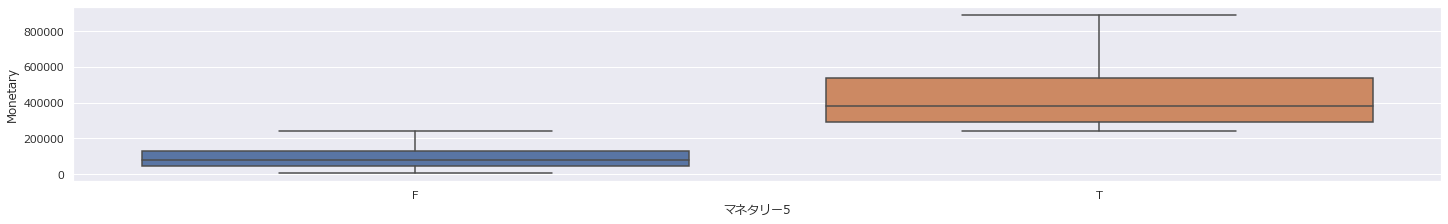

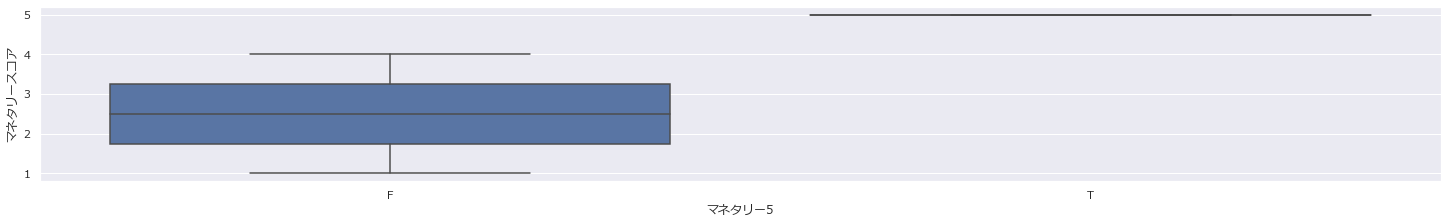

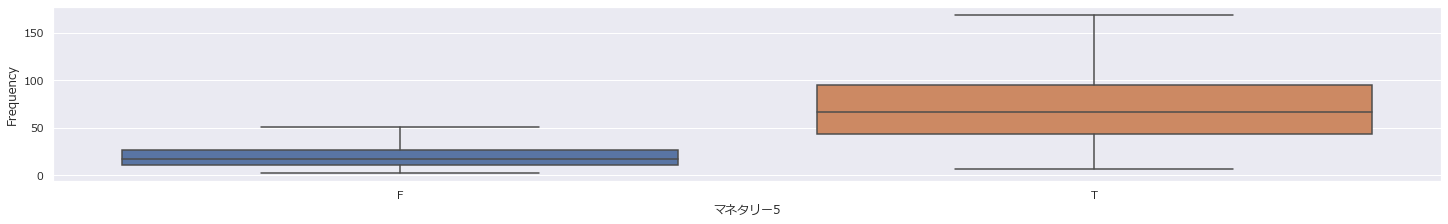

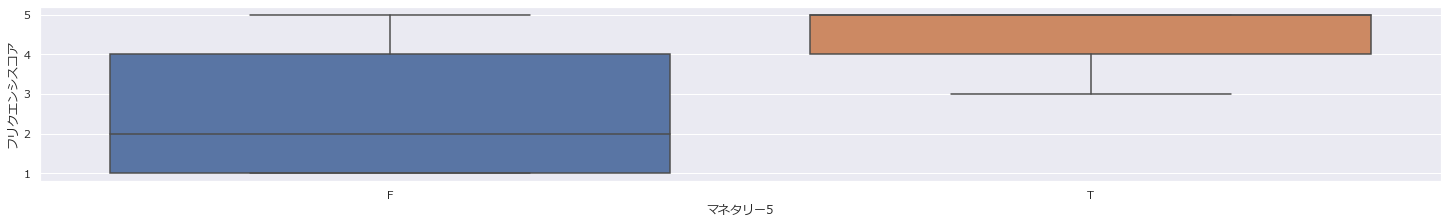

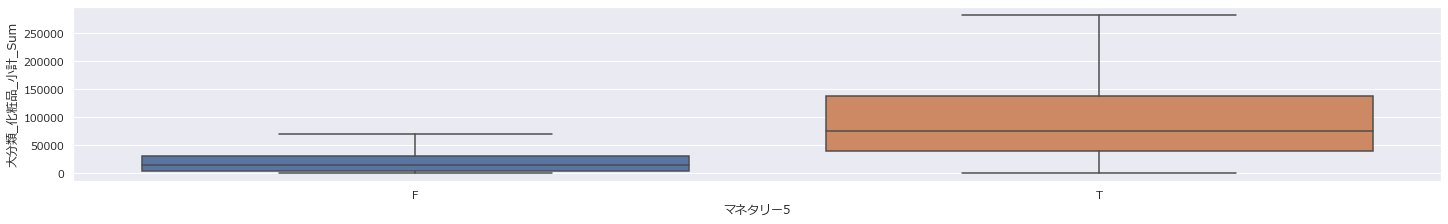

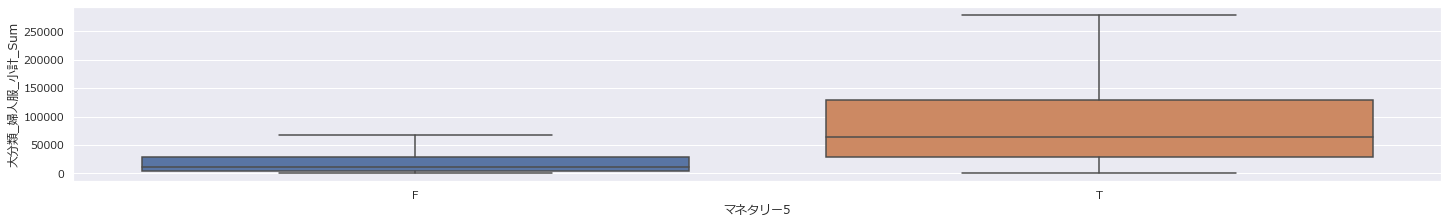

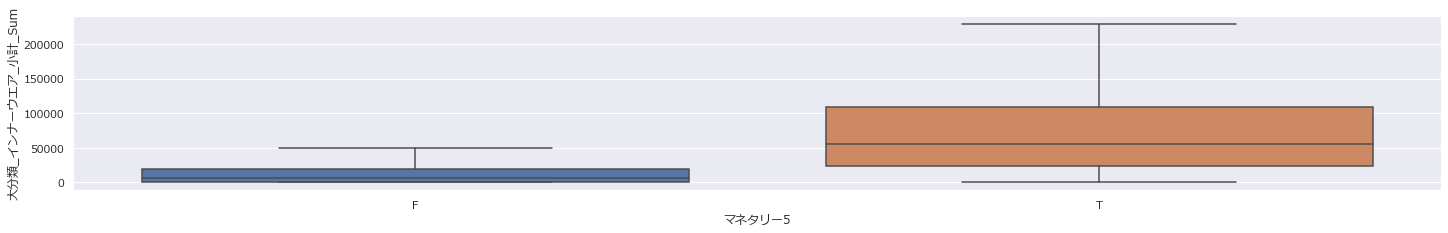

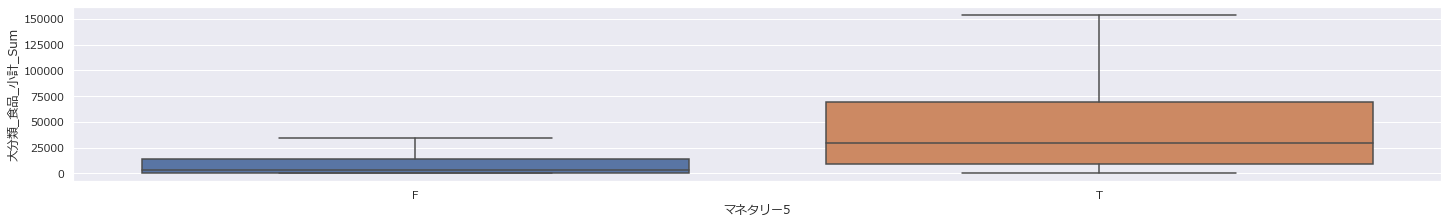

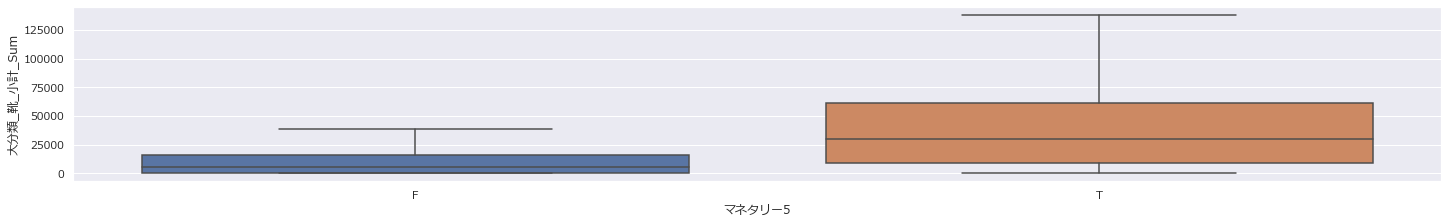

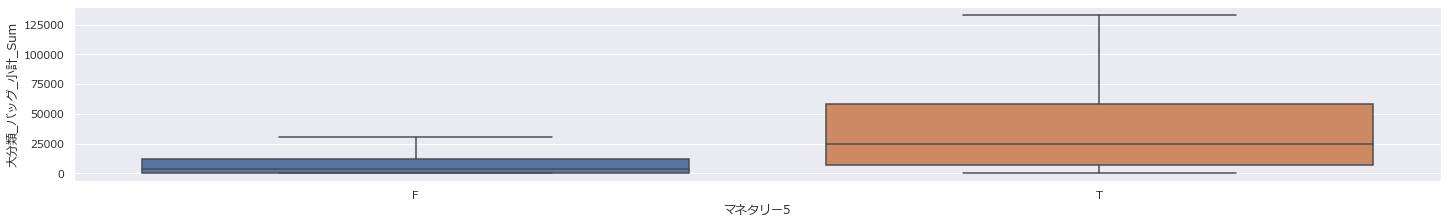

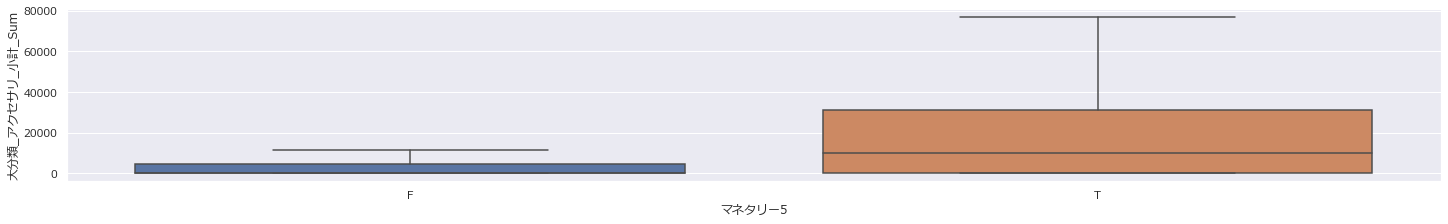

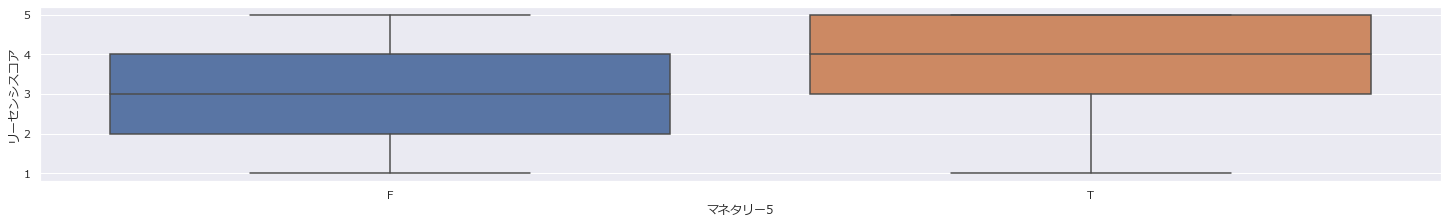

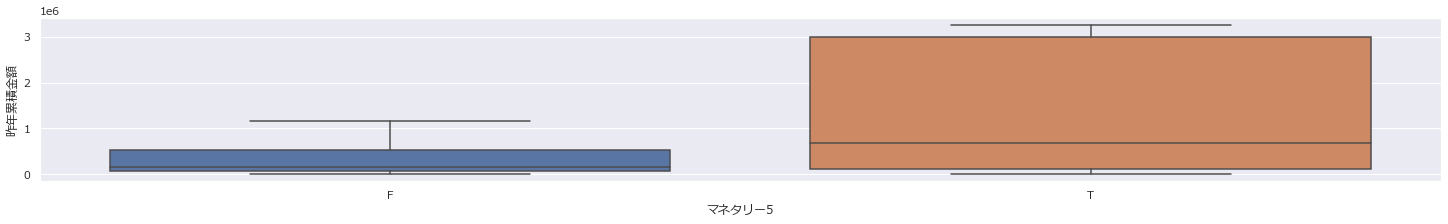

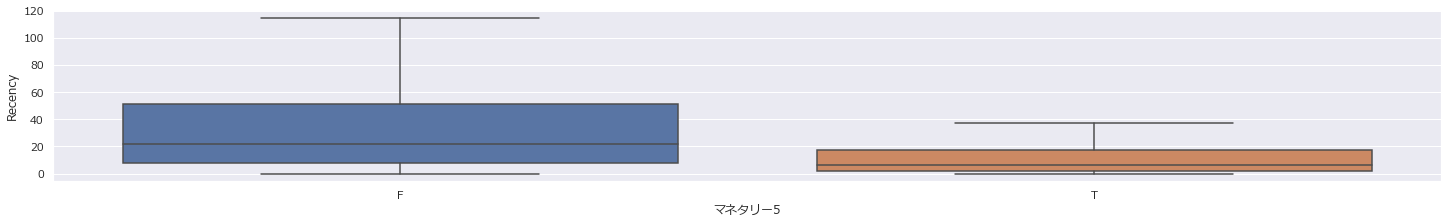

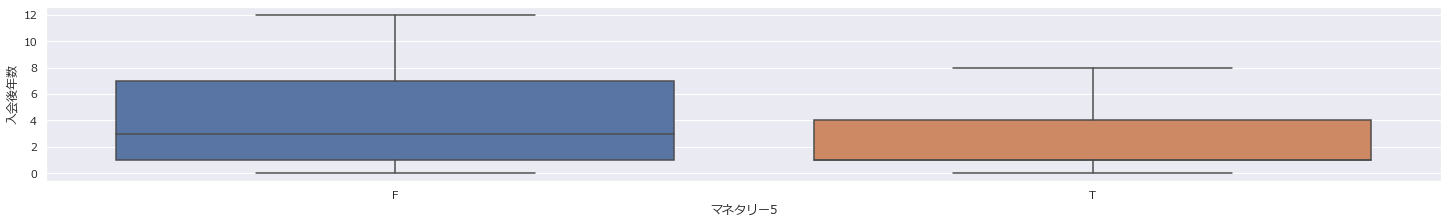

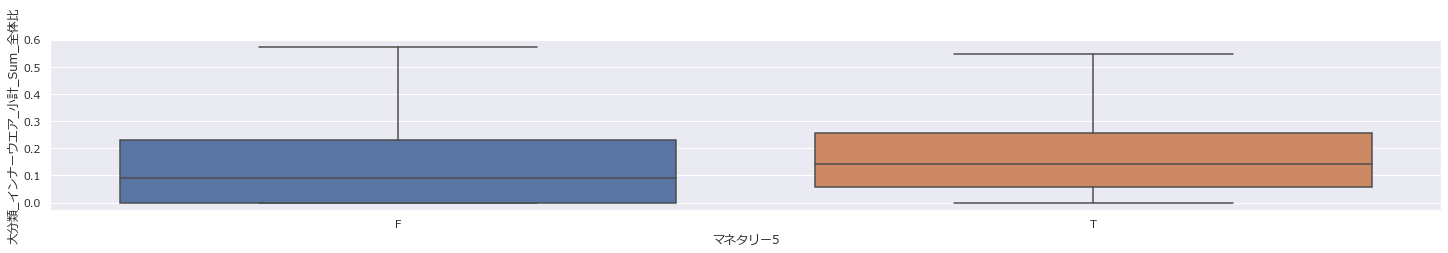

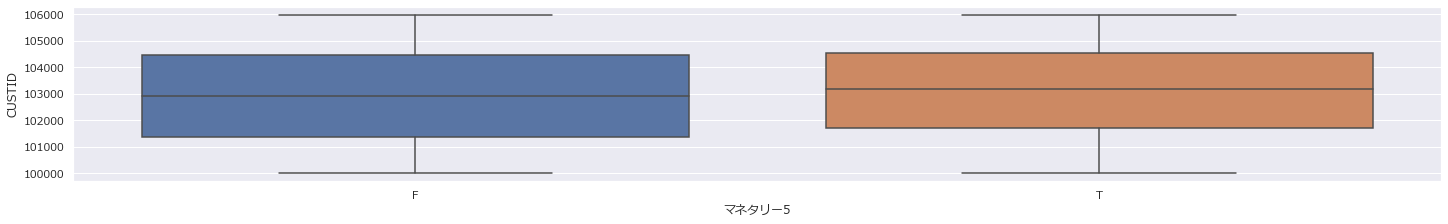

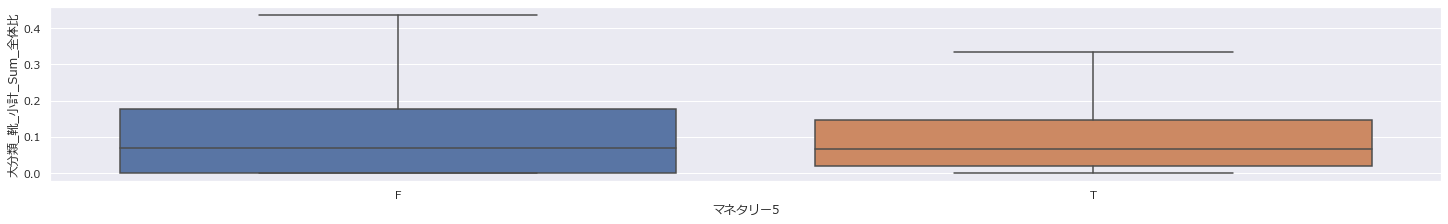

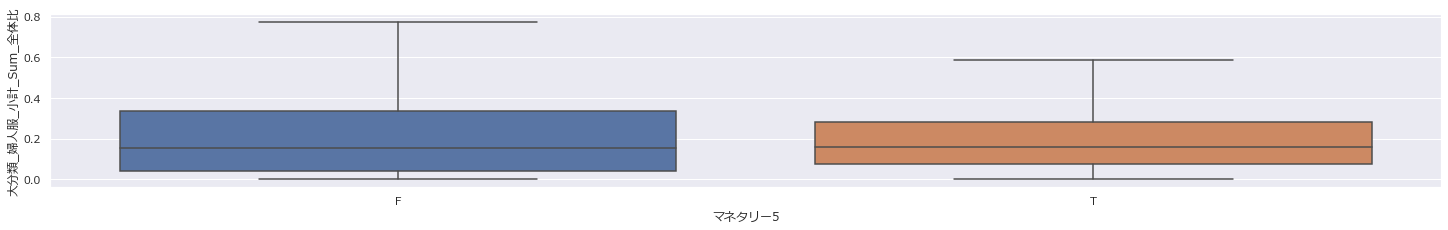

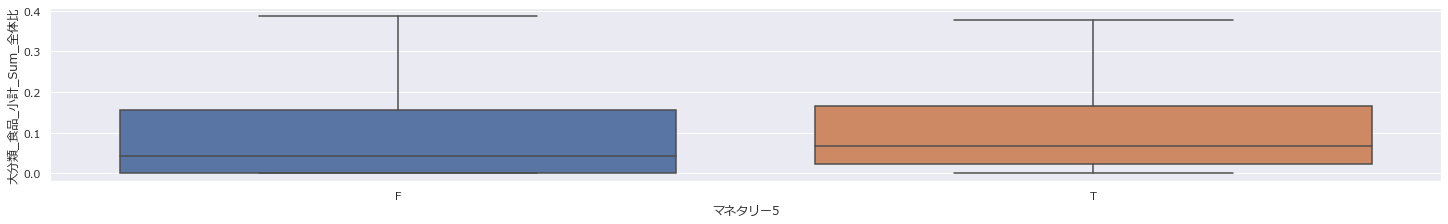

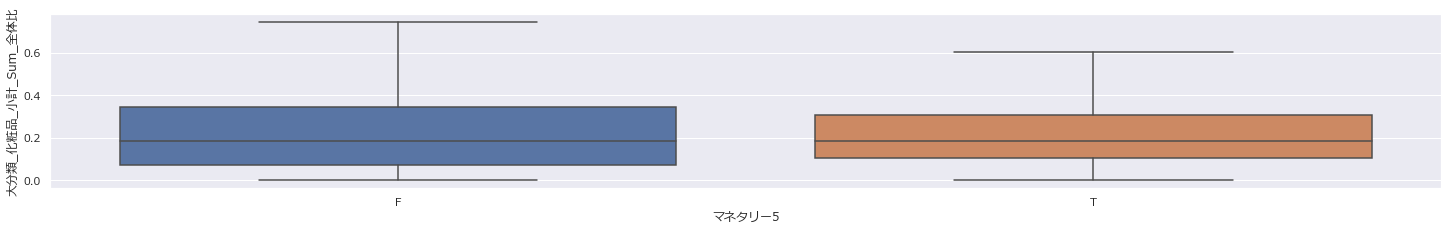

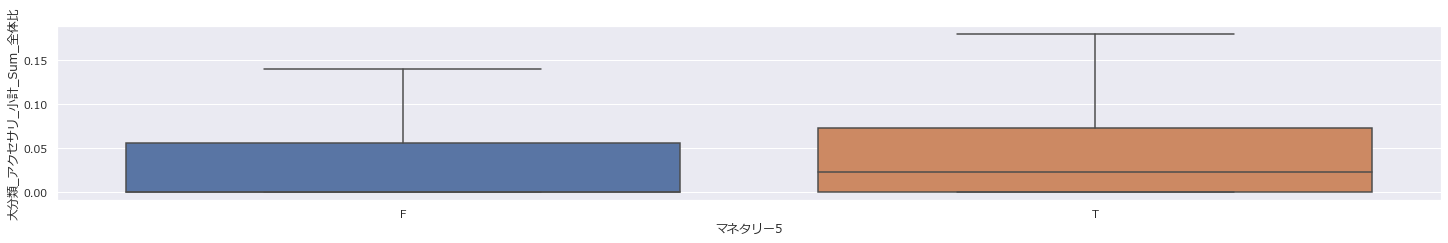

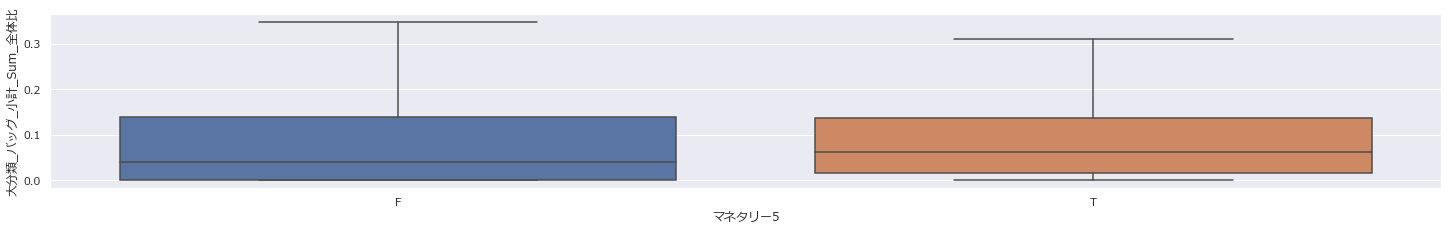

In [9]:
#箱ひげ図表示
boxplot(df2,df_anova['フィールド'],grpcolumn)

In [10]:
import sys
import pandas as pd
print(sys.version)
print(pd.__version__)
import scipy
print(scipy.__version__)
import statsmodels
print(statsmodels.__version__)


3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]
1.4.1
1.8.0
0.13.2
